In [328]:
# Boilerplate at top of file
# %load_ext autoreload
import rpy2
%load_ext rpy2.ipython
# %autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os

In [309]:
data_dir = '../data/'

direcs = map(lambda x: data_dir + x,[
        'look_left_good/events',
        'look_left_bad/events',
#         'look_right_good/events',
#         'look_right_bad/events',
    ])
# flatten all event files into a single list of file paths
event_files = reduce(lambda l,r:l + r,
                     map(lambda x: 
                         map(lambda y: x + '/' + y, os.listdir(x)), 
                         direcs
                        )
                    )
print event_files

['../data/look_left_good/events/1453773920-0.csv', '../data/look_left_good/events/1453773920-1.csv', '../data/look_left_good/events/1453773920-2.csv', '../data/look_left_good/events/1453837633-0.csv', '../data/look_left_good/events/1453837633-1.csv', '../data/look_left_good/events/1453837633-2.csv', '../data/look_left_good/events/1453837633-3.csv', '../data/look_left_good/events/1453837718-0.csv', '../data/look_left_good/events/1453837718-1.csv', '../data/look_left_good/events/1453837718-2.csv', '../data/look_left_good/events/1453837718-3.csv', '../data/look_left_good/events/1453837718-4.csv', '../data/look_left_good/events/1453837718-5.csv', '../data/look_left_good/events/1453872068-0.csv', '../data/look_left_good/events/1453872068-1.csv', '../data/look_left_good/events/1453872068-2.csv', '../data/look_left_good/events/1453872068-3.csv', '../data/look_left_good/events/1453872068-4.csv', '../data/look_left_good/events/1453872068-5.csv', '../data/look_left_good/events/1453872068-6.csv',

# Example of the event data

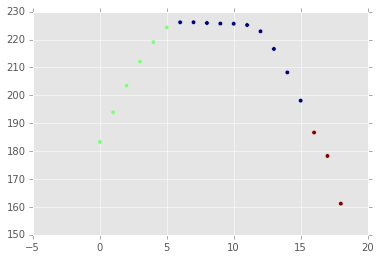

In [310]:
df = pd.read_csv('../data/look_left_good/events/1453773920-0.csv')
plt.scatter(df.index, df['noseX'],c=df['class'])

# Feature Engineering and Exploratory

In [321]:
def generate_signal_features(df, f):
    sampling_rate = (df['time'].max() - df['time'].min()) / len(df)
    data_points = float(len(df))
    row=dict()
    row['signal_length'] = df['time'].max() - df['time'].min()
#     row['noseX_delta_max'] = df['noseX'].max() - df['noseX'].min(0)
    row['log_noseX_delta_max'] = np.log(df['noseX'].max() - df['noseX'].min(0))
    row['front_face_count'] = sum(df['isFrontFace'] == 1) / data_points
#     row['neutral_count'] = sum(df['class'] == 0)
    row['prop_neutral_count'] = sum(df['class'] == 0) / data_points
    row['number_of_timestamps'] = len(df)
#     row['max_speed'] = np.mean(df['noseX_1_steps'].apply(np.abs)) / sampling_rate
    row['turn_sentiment'] = df['turn_sentiment'].max()
    row['file_name'] = f
    return row

In [340]:
events = []
for f in event_files:
    row = generate_signal_features(pd.read_csv(f), f)
    events.append(row)
df_events = pd.DataFrame(events)
class_col = 'turn_sentiment'
active_features = df_events._get_numeric_data().columns.tolist()
df_num = df_events[active_features]
df_a = df_events[active_features + [class_col]]
print active_features

['front_face_count', 'log_noseX_delta_max', 'number_of_timestamps', 'prop_neutral_count', 'signal_length']


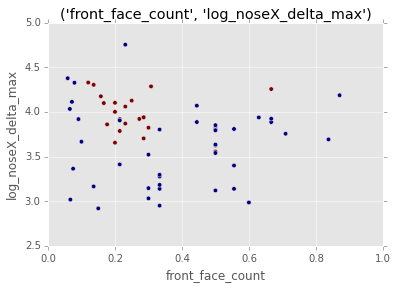

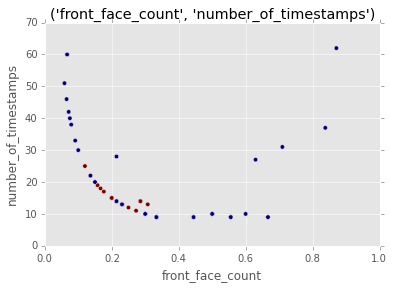

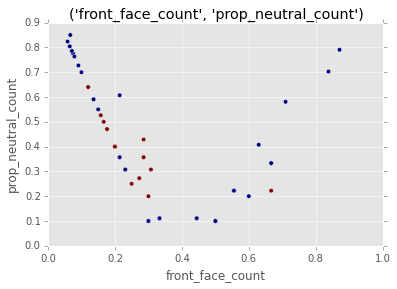

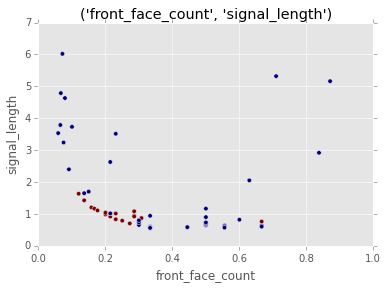

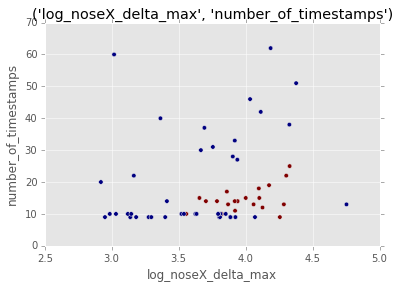

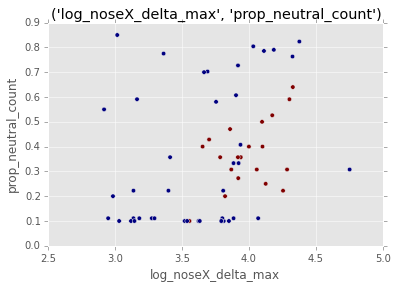

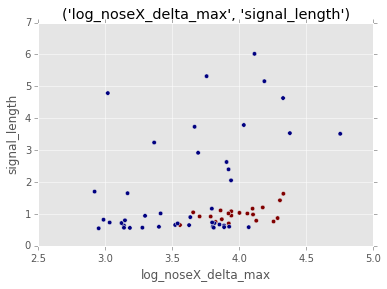

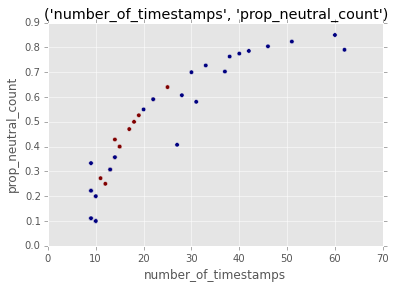

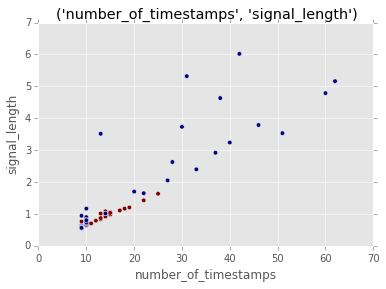

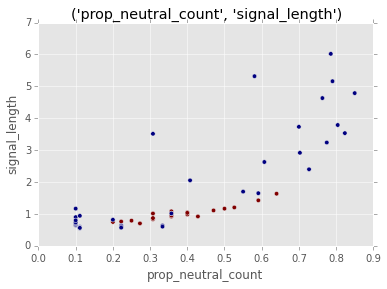

In [341]:
import itertools
from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(df_events['turn_sentiment'])
for pair in itertools.combinations(active_features, 2):
    plt.figure()
    plt.title(pair)
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.scatter(df_events[pair[0]], df_events[pair[1]],
                c=Y)

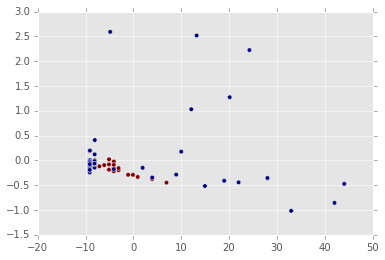

In [323]:
pca = PCA(n_components=2)
X = pca.fit_transform(df_events[active_features])
plt.scatter(X[:,0], X[:,1], c = Y)
# red is good head turns
# blue is bad behavior

# Classifier


Call:
glm(formula = turn_sentiment ~ ., family = "binomial", data = df_a)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3391  -0.1549  -0.0143   0.1414   3.1356  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)   
(Intercept)          -19.5862    10.0879  -1.942  0.05219 . 
front_face_count     -14.1290     4.9039  -2.881  0.00396 **
log_noseX_delta_max    7.3083     2.8376   2.576  0.01001 * 
number_of_timestamps  -0.2695     0.2901  -0.929  0.35284   
prop_neutral_count    14.7309     7.3415   2.007  0.04480 * 
signal_length         -4.6480     2.3829  -1.951  0.05111 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 80.201  on 62  degrees of freedom
Residual deviance: 22.300  on 57  degrees of freedom
AIC: 34.3

Number of Fisher Scoring iterations: 8



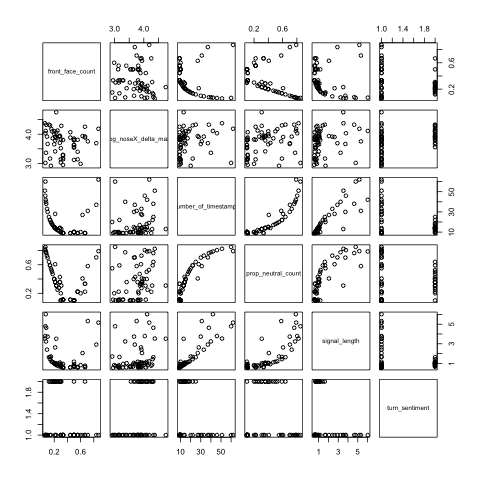

In [348]:
%%R -i df_a 
plot(df_a)
m <- glm(turn_sentiment ~ ., data=df_a, family='binomial')
summary(m)